# <font color=blue><div align="center">TD-TP 4 - EXERCICE 2</div></font>

### <font color=blue><div align="center">10-02-2023</div></font>

## Modules

In [1]:
# Modules de base
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Module relatif à Gurobi
from gurobipy import *

# Les Données

In [5]:
nombre_de_sommets = 8
Sommets = range(nombre_de_sommets)

# C1 : dict[(int, int) : int] 
## C1[(i, j)] représente le coût de l'arc (i, j) sur le critère 1
C1 = {(0, 1) : 4,
      (0, 2) : 5,
      (0, 3) : 9,
      (1, 4) : 5,
      (1, 5) : 3,
      (2, 4) : 8,
      (2, 5) : 6,
      (2, 6) : 5,
      (3, 5) : 6,
      (3, 6) : 7,
      (4, 7) : 7,
      (5, 7) : 3,
      (6, 7) : 3
     }

# C2 : dict[(int, int) : int] 
## C2[(i, j)] représente le coût de l'arc (i, j) sur le critère 2
C2 = {(0, 1) : 7,
      (0, 2) : 8,
      (0, 3) : 4,
      (1, 4) : 7,
      (1, 5) : 9,
      (2, 4) : 3,
      (2, 5) : 5,
      (2, 6) : 5,
      (3, 5) : 4,
      (3, 6) : 7,
      (4, 7) : 1,
      (5, 7) : 4,
      (6, 7) : 3
     }

# critereAOptimiser : int
critereAOptimiser = 1      # vaut 1 ou 2

assert critereAOptimiser == 1 or critereAOptimiser == 2

# C, C_prim : dict[(int, int) : int]
## C et C_prim sont des variables globales permettant de référencer le dictionnaire
### C1 ou C2 en fonction de la valeur attribuée à la variable critereAOptimiser
C = C_prim = None

if critereAOptimiser == 1:
    C = C1
    C_prim = C2
else:
    C = C2
    C_prim = C1

assert C is not None
assert C_prim is not None

range(0, 8)


# Question 4

In [19]:
def generer_PCC_model():
    """None -> Model
    instancie et retourne le modèle Gurobi correspondant au Programme Linéaire calculant
    le Plus Court Chemin du sommet 0 au sommet 7. Il utilisera les variables globales C et 
    C_prim définies précédemment."""
    
    # -- Initialisation du modèle --
    # m : Model
    m = Model("TD4-Exo2")
    
    # -- Ajout des variables  --
    # X: dict[(int : int) : Var]
    # X: Un dictionnaire de variables binaires où chaque clé est un tuple représentant
    # un arc (i, j) et chaque variable indique si l'arc fait partie du plus court chemin (1) ou non (0).
    X = {(i, j) :  m.addVar(vtype = GRB.BINARY, name = f'x_{i}_{j}') for i, j in C}
    
    # -- Ajout des contraintes --
    # ConstrVertex0 : Constr
    # ConstrVertex0 : Une contrainte garantissant qu'exactement un arc sort du sommet de départ (sommet 0)
    ConstrVertex0 = m.addConstr(quicksum([X[(0, j)] for i, j in C if i == min(Sommets)]) == 1, name='ConstrVertex0')

    # ConstrOtherVertexDict : Dict[int : Constr]
    # ConstrOtherVertexDict: Un dictionnaire de contraintes pour chaque sommet intermédiaire, assurant que le nombre d'arcs 
    # entrants est égal au nombre d'arcs sortants. Cela garantit la continuité du chemin du sommet de départ au sommet d'arrivée.
    ConstrOtherVertexDict = {i : m.addConstr(quicksum([X[k, i] for k, l in C if l == i]) == quicksum([X[i, j] for l, j in C if l == i]),
                                             name=f'constr{i}') for i in Sommets if i != min(Sommets) and i != max(Sommets)}
    
    # -- Ajout de la fonction objectif --
    # La fonction objectif est définie pour minimiser la somme des coûts des arcs sélectionnés pour le chemin, en utilisant le critère de coût principal (C).

    # [C[(i, j)]*x_i_j for (i, j), x_i_j in X.items()]: Cette compréhension de liste génère une séquence d'expressions où chaque expression est le 
    # produit du coût d'un arc (i, j) par la variable binaire correspondante x_i_j qui indique si l'arc est utilisé dans le chemin ou non. 
    # C[(i, j)] est le coût de l'arc (i, j) selon le critère d'optimisation principal (C1 ou C2), et X est le dictionnaire contenant les variables 
    # de décision pour chaque arc potentiel dans le graphe. Pour chaque paire clé-valeur dans X (où la clé est un tuple (i, j) représentant un arc 
    # et la valeur est la variable binaire x_i_j associée), le produit C[(i, j)] * x_i_j représente le coût de sélection de cet arc dans le chemin.

    # GRB.MINIMIZE: Ceci spécifie l'objectif de minimisation de la fonction objectif. Dans le contexte de ce problème de plus court chemin, 
    # cela signifie que le solveur cherchera la configuration des variables X qui minimise la somme totale des coûts des arcs sélectionnés, 
    # conformément au critère de coût C.


    m.setObjective(quicksum([C[(i, j)]*x_i_j for (i, j), x_i_j in X.items()]), GRB.MINIMIZE)
    # -
    
    # -- Choix d'un paramétrage d'affichage minimaliste --
    m.params.outputflag = 0 # mode muet
    # - 

    # -- Mise à jour du modèle  --
    m.update()
    # -
    
    return m
    
    
    

In [16]:
m = generer_PCC_model()

# -- Affichage en mode texte du PL --
m.write("shortest_path.lp")
#- 

# -- Résolution --
m.optimize()

# -- Vérification du statut et Affichage (le cas échéant) des solutions --
if m.status == GRB.INFEASIBLE:
    print("\n LE PROGRAMME N'A PAS DE SOLUTION!!!")
elif m.status == GRB.UNBOUNDED:
    print("\n LE PROGRAMME EST NON BORNÉ!!!")
else:
    # valeur_PCC : int          
    ## la valeur du plus court chemin du sommet 0 au sommet 7.
    valeur_PCC = int(m.objVal)                      # valeur_PCC à compléter
    print("\n\nLe chemin le plus court a pour longueur : {}".format(valeur_PCC))
    
    # PCC : str
    ## La chaine correspondant au plus court chemin.
    PCC = ""                
    Path = list()
    current_vertex = min(Sommets)
    while current_vertex != max(Sommets):
        Path.append(str(current_vertex))
        current_vertex = max([j for j in Sommets if (current_vertex, j) in C], 
                             key=lambda j : m.getVarByName(f'x_{current_vertex}_{j}').x)
    Path.append(str(current_vertex))
    PCC = "->".join(Path)
    print("Il s'agit de : \n", PCC) 

{(0, 1): <gurobi.Var *Awaiting Model Update*>, (0, 2): <gurobi.Var *Awaiting Model Update*>, (0, 3): <gurobi.Var *Awaiting Model Update*>, (1, 4): <gurobi.Var *Awaiting Model Update*>, (1, 5): <gurobi.Var *Awaiting Model Update*>, (2, 4): <gurobi.Var *Awaiting Model Update*>, (2, 5): <gurobi.Var *Awaiting Model Update*>, (2, 6): <gurobi.Var *Awaiting Model Update*>, (3, 5): <gurobi.Var *Awaiting Model Update*>, (3, 6): <gurobi.Var *Awaiting Model Update*>, (4, 7): <gurobi.Var *Awaiting Model Update*>, (5, 7): <gurobi.Var *Awaiting Model Update*>, (6, 7): <gurobi.Var *Awaiting Model Update*>}
<gurobi.Model Continuous instance TD4-Exo2: 0 constrs, 0 vars, Parameter changes: Username=(user-defined)>


Le chemin le plus court a pour longueur : 10
Il s'agit de : 
 0->1->5->7


# Question 6

In [23]:
# epsilon : float
epsilon = 0.00001

m = generer_PCC_model()

# -- Résolution --
m.optimize()

# otherObjExpr : LinExpr
## represente l'expression lineaire de la fonction objectif correspondant au critère non optimisé (C_prim)
otherObjExpr = quicksum([cout_i_j*m.getVarByName(f'x_{i}_{j}') for (i, j), cout_i_j in C_prim.items()])

it = 0
Liste_solutions_efficaces = list()
while m.status != GRB.INFEASIBLE:
    if critereAOptimiser == 1:
        sol = (m.objVal, otherObjExpr.getValue())
        Liste_solutions_efficaces.append(sol)
    else:
        sol = (otherObjExpr.getValue(), m.objVal)
        Liste_solutions_efficaces.append(sol)

    print("La solution trouvée à l'itération {} est : {}".format(it, sol))
    # -- Affichage de la solution dans l'espace de decision
    PCC = ""                
    Path = list()
    current_vertex = min(Sommets)
    while current_vertex != max(Sommets):
        Path.append(str(current_vertex))
        current_vertex = max([j for j in Sommets if (current_vertex, j) in C], 
                             key=lambda j : m.getVarByName(f'x_{current_vertex}_{j}').x)
    Path.append(str(current_vertex))
    PCC = "->".join(Path)
    print("Il s'agit de : \n", PCC) 
    # - 
    it += 1
    # -- Ajout de l'epsilon constraint
    m.addConstr(otherObjExpr <= otherObjExpr.getValue() - epsilon, name=f'epsilon_constraint_{it}')
    # -- Mise à jour du modèle  --
    m.update()
    # -- Résolution --
    m.optimize()
    

La solution trouvée à l'itération 0 est : (10.0, 20.0)
Il s'agit de : 
 0->1->5->7
La solution trouvée à l'itération 1 est : (13.0, 16.0)
Il s'agit de : 
 0->2->6->7
La solution trouvée à l'itération 2 est : (16.0, 15.0)
Il s'agit de : 
 0->1->4->7
La solution trouvée à l'itération 3 est : (18.0, 12.0)
Il s'agit de : 
 0->3->5->7


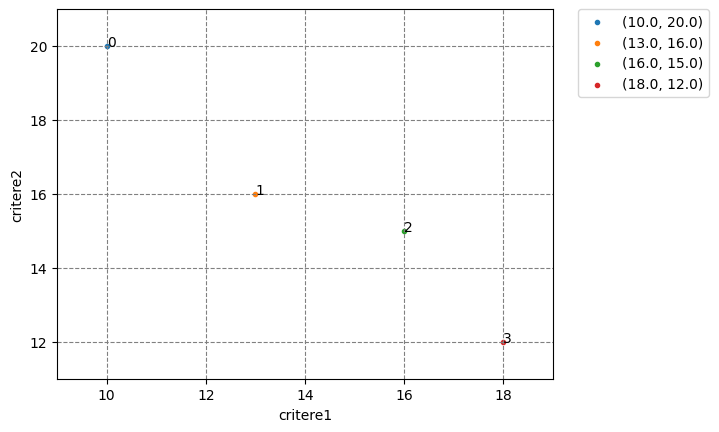

In [24]:
#Z1 : List[float]

Z1 = [sol[0] for sol in Liste_solutions_efficaces]
#Z2 : List[float]
Z2 = [sol[1] for sol in Liste_solutions_efficaces]

k = 0
for i, j in zip(Z1, Z2):
    plt.scatter(i, j, marker='.', label=str((i,j)))
    plt.annotate(str(k), (i, j))
    k += 1

plt.grid(linestyle='--', color='gray')
plt.xlim((min(Z1) - 1, max(Z1) + 1)) 
plt.ylim((min(Z2) - 1, max(Z2) + 1))

plt.xlabel('critere1')
plt.ylabel('critere2')
plt.legend(bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0.)